<a href="https://colab.research.google.com/github/mablejoh/Pagination-SearchLibrary/blob/master/NLP_GER_ENG_MT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import and merge all the three datasets.**

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
import re
import numpy as np
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import contractions

In [ ]:
# Mounting google drive to access files.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Step 1: Load the datasets (limit to 200000 sentences each)
def load_sentences(file_path, num_sentences=200000):
    with open(file_path, 'r', encoding='utf-8') as f:
        sentences = f.readlines()[:num_sentences]
    return sentences

europarl_german_sentences = load_sentences('/content/drive/MyDrive/Capstone_Dataset/europarl/europarl-v7_de_en.txt')
europarl_english_sentences = load_sentences('/content/drive/MyDrive/Capstone_Dataset/europarl/europarl-v7_en_de.txt')

news_german_sentences = load_sentences('/content/drive/MyDrive/Capstone_Dataset/news/news-commentary-v9_de_en.txt')
news_english_sentences = load_sentences('/content/drive/MyDrive/Capstone_Dataset/news/news-commentary-v9_en_de.txt')


common_german_sentences = load_sentences('/content/drive/MyDrive/Capstone_Dataset/commoncrawl/commoncrawl_de_en.txt')
common_english_sentences = load_sentences('/content/drive/MyDrive/Capstone_Dataset/commoncrawl/commoncrawl_en_de.txt')


# Combine sentences from all datasets
all_german_sentences = europarl_german_sentences + news_german_sentences + common_german_sentences
all_english_sentences = europarl_english_sentences + news_english_sentences + common_english_sentences


# Convert sentences to pandas DataFrame
data = pd.DataFrame({
    'german': all_german_sentences,
    'english': all_english_sentences
})




**Step 2: Data cleansing**

In [ ]:
#Inspecting the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   german   600000 non-null  object
 1   english  600000 non-null  object
dtypes: object(2)
memory usage: 9.2+ MB


In [ ]:
data.describe()

,german,english
count,600000,600000
unique,594288,591219
top,\n,\n
freq,564,1011


In [ ]:
#Check for duplicates with
data.duplicated().sum()

3645

Remove Duplicates: Ensure that no duplicate sentence pairs exist in the dataset.

In [ ]:
# Remove duplicates in the combined dataset
data.drop_duplicates(inplace=True)

In [ ]:
#checking again mising values
data.duplicated().sum()

0

Handle Missing Data: Remove rows where either the German or English sentence is missing.

In [ ]:
#Handle Missing Values
data.isnull().sum()

,0
german,0
english,0


In [ ]:
# Define a function to count words
def word_count(text):
    return len(text.split())

# Apply the word count filter
data = data[
    (data['german'].apply(word_count) >= 3) &
    (data['german'].apply(word_count) <= 50) &
    (data['english'].apply(word_count) >= 3) &
    (data['english'].apply(word_count) <= 50)
]

print(f"Dataset size after removing noisy data: {len(data)}")


Dataset size after removing noisy data: 562804


In [ ]:
import re

# Define text normalization function
def normalize_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters, HTML tags, etc.
    text = re.sub(r'[^a-zäöüßA-ZÄÖÜß\s]', '', text)
    return text.strip()

# Apply normalization to source and target
data['german'] = data['german'].apply(normalize_text)
data['english'] = data['english'].apply(normalize_text)

print("Text normalization completed.")


Text normalization completed.


In [ ]:
# Calculate counts for source and target
source_word_count = data['german'].str.split().apply(len).sum()
target_word_count = data['english'].str.split().apply(len).sum()

print(f"Total german word count: {source_word_count}")
print(f"Total english word count: {target_word_count}")


Total german word count: 11211227
Total english word count: 11816011


In [ ]:
# Optional: Downsample larger dataset
min_size = min(len(data['german']), len(data['english']))
data = data.sample(n=min_size, random_state=42)

print(f"Dataset size after balancing: {len(data)}")


Dataset size after balancing: 562804


In [ ]:
# Remove rows with missing values
data.dropna(subset=['german', 'english'], inplace=True)

In [ ]:
# Save the combined dataset to a new file for future step
data.to_csv('/content/drive/MyDrive/Capstone_Dataset/merged_de_en_dataset.csv', index=False, sep='\t')

In [ ]:
data.head()

,german,english
517428,mit kilogramm traglast und einer reichweite v...,with a payload capacity of kilograms and a re...
5924,wir halten es für unverzichtbar daß nicht nur ...,we believe it is imperative not just to make e...
466790,frans van anraat geboren ist ein niederländis...,frans van anraat born in is a dutch businessman
255403,bei höher entwickelten produkten ist die werts...,but it will be unable to review the longerterm...
560205,das restaurant war zu klein morgens kein platz...,while i ask for a nonsmoking room during booki...


Now we have a merged dataset containing German-English sentence pairs with no duplicates or missing values, ready for further NLP preprocessing.

**Step 3: NLP pre processing - Dataset suitable to be used for AIML model learning**

**Text Cleaning:** Clean the text by lowercasing, removing special characters, punctuation, and extra whitespace.

In [ ]:
# Refined function to clean text with language-specific considerations

def clean_text(text, language='de'):
  # Check if the input is a string
    if isinstance(text, str):
      text = text.lower()
      text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  #Improved URL removal

      #Handle contractions in english
      if language == 'en':
          text = contractions.fix(text)

      uncommon_char_pattern = r"[^a-zA-ZäöüßÄÖÜẞ\s0-9.,!?']" if language == 'en' else r"[^a-zA-ZäöüßÄÖÜẞ\s0-9.,!?]"
      text = re.sub(uncommon_char_pattern, "", text)
      text = re.sub(r"\d+", "<number>", text) #Optional number replacement


      if language == 'de':
          # German abbreviations (expand this list if needed)
          german_abbreviations = {
              "z.B.": "zum Beispiel", "d.h.": "das heißt", "u.a.": "unter anderem",
              "v.a.": "vor allem", "ca.": "circa", "bzw.": "beziehungsweise", "usw.": "und so weiter"
          }
          for abbr, expansion in german_abbreviations.items():
              text = text.replace(abbr.lower(), expansion.lower())

      text = re.sub(r"[!?]{2,}", "!", text)
      text = re.sub(r"[.]{2,}", ".", text)
      text = re.sub(r"\s+", " ", text).strip()
      return text

    else:
        # Handle non-string values (e.g., NaN)
        return ""  # Or any other suitable replacement


**Length Filtering** : Remove sentences that are either too short (single words) or too long (more than 50 words).

In [ ]:
# Function to check if sentence length is acceptable
def length_filter(sentence, min_length=3, max_length=50):
    num_words = len(sentence.split())
    return min_length <= num_words <= max_length



In [ ]:
# Process the data in chunks and remove duplicates & missing values
def process_data_in_chunks(input_file, output_file, chunk_size=50000):
    # Create an empty list to store processed data
    processed_data = []

    # Read the file in chunks
    for chunk in pd.read_csv(input_file, sep='\t', header=None, names=['german', 'english'], chunksize=chunk_size):
        # Clean the text columns
        chunk['german'] = chunk['german'].apply(lambda x: clean_text(x, language='de'))
        chunk['english'] = chunk['english'].apply(lambda x: clean_text(x, language='en'))



        # Remove rows with missing values
        chunk.dropna(subset=['german', 'english'], inplace=True)

        # Apply length filtering
        chunk = chunk[chunk['german'].apply(length_filter) & chunk['english'].apply(length_filter)]

        # Remove duplicates
        chunk.drop_duplicates(inplace=True)

        # Append the cleaned chunk to the list
        processed_data.append(chunk)

    # Combine all processed chunks into a single DataFrame
    final_data = pd.concat(processed_data, ignore_index=True)

    # Save the final cleaned data to a CSV file
    final_data.to_csv(output_file, index=False, sep='\t')

    return final_data

In [ ]:
# File paths
input_file = '/content/drive/MyDrive/Capstone_Dataset/merged_de_en_dataset.csv'
output_file = '/content/drive/MyDrive/Capstone_Dataset/processed_de_en_dataset.csv'

# Process the data
cleaned_data = process_data_in_chunks(input_file, output_file)

# Display the first few rows of the cleaned dataset
print(cleaned_data.head())

                                              german  \
0  mit kilogramm traglast und einer reichweite vo...   
1  wir halten es für unverzichtbar daß nicht nur ...   
2  frans van anraat geboren ist ein niederländisc...   
3  bei höher entwickelten produkten ist die werts...   
4  das restaurant war zu klein morgens kein platz...   

                                             english  
0  with a payload capacity of kilograms and a rea...  
1  we believe it is imperative not just to make e...  
2    frans van anraat born in is a dutch businessman  
3  but it will be unable to review the longerterm...  
4  while i ask for a nonsmoking room during booki...  


The dataset is now cleaned, with the following processing steps completed:

1. Duplicates Removed: No sentence pairs are duplicated.
2. Missing Data Handled: Rows with missing German or English sentences are removed.
3. Text Normalized: All text is lowercased, special characters and punctuation are removed, and extra whitespaces are trimmed.
4. Length Filter Applied: Sentences that are too short or too long are filtered out.

**Exploring Data**

**Sentence Length Distribution** Sentence length distribution can be represented by the number of words per sentence. We can plot a histogram or calculate statistics (mean, median, etc.) for the sentence lengths.

Average German sentence length: 19.95879095375475
Average English sentence length: 21.046709417578338


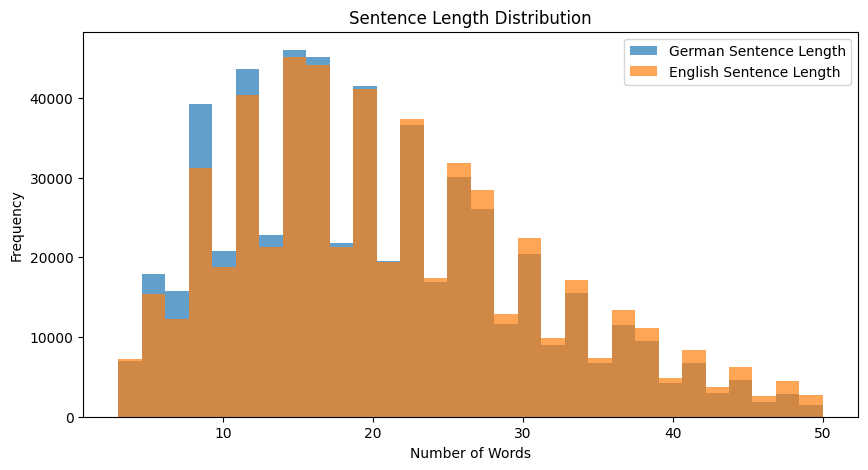

German Sentence Length Statistics:
count    560144.000000
mean         19.958791
std           9.797813
min           3.000000
25%          12.000000
50%          18.000000
75%          26.000000
max          50.000000
Name: german_length, dtype: float64

English Sentence Length Statistics:
count    560144.000000
mean         21.046709
std          10.163312
min           3.000000
25%          13.000000
50%          20.000000
75%          28.000000
max          50.000000
Name: english_length, dtype: float64


In [ ]:
# Basic statistics on sentence lengths
cleaned_data['german_length'] = cleaned_data['german'].apply(lambda x: len(x.split()))
cleaned_data['english_length'] = cleaned_data['english'].apply(lambda x: len(x.split()))

# Display average, min, and max sentence lengths
print("Average German sentence length:", cleaned_data['german_length'].mean())
print("Average English sentence length:", cleaned_data['english_length'].mean())

# Plot sentence length distributions (optional, requires matplotlib)
import matplotlib.pyplot as plt

# Histogram for German sentence lengths
plt.figure(figsize=(10, 5))
plt.hist(cleaned_data['german_length'], bins=30, alpha=0.7, label='German Sentence Length')
plt.hist(cleaned_data['english_length'], bins=30, alpha=0.7, label='English Sentence Length')
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Display basic statistics
print("German Sentence Length Statistics:")
print(cleaned_data['german_length'].describe())

print("\nEnglish Sentence Length Statistics:")
print(cleaned_data['english_length'].describe())



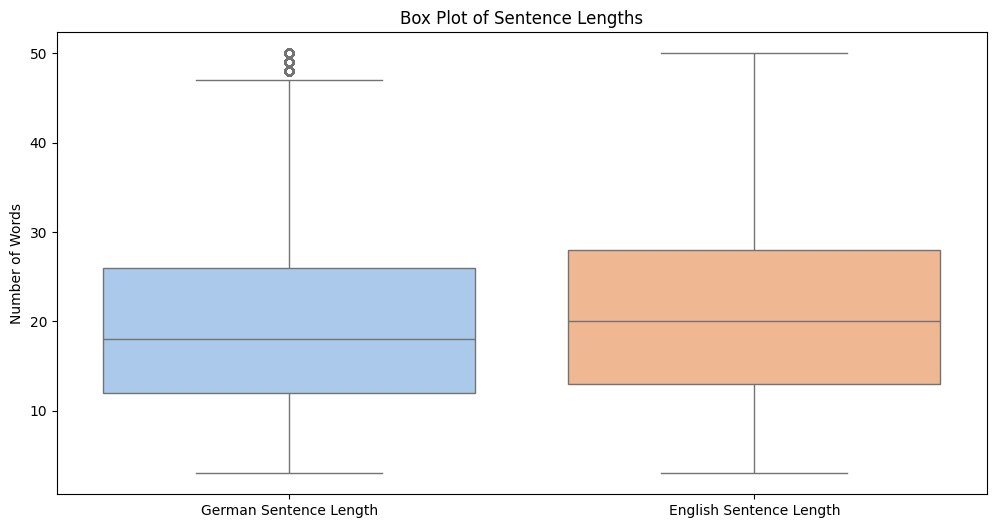

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot for sentence lengths
plt.figure(figsize=(12, 6))
sns.boxplot(data=[cleaned_data['german_length'], cleaned_data['english_length']], palette="pastel")
plt.xticks([0, 1], ['German Sentence Length', 'English Sentence Length'])
plt.title('Box Plot of Sentence Lengths')
plt.ylabel('Number of Words')
plt.show()


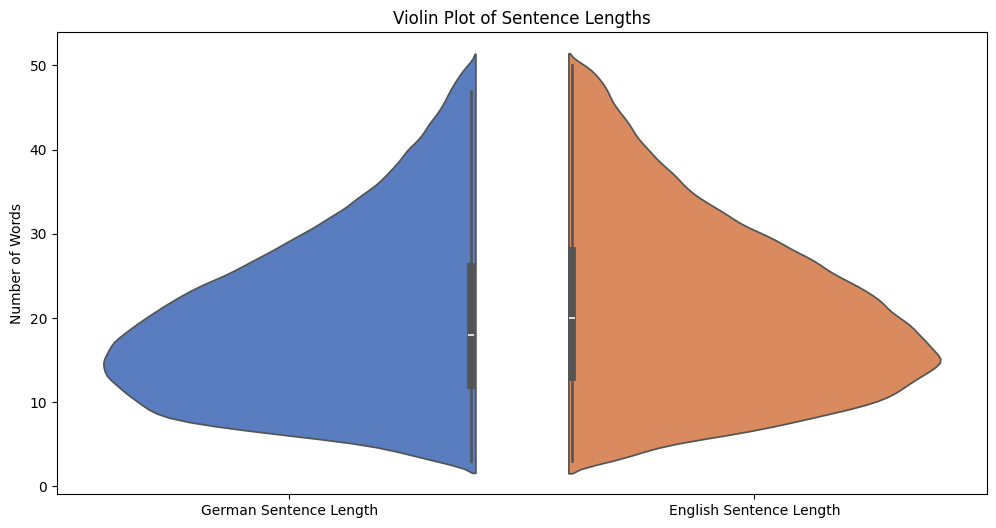

In [ ]:
# Violin plot for sentence lengths
plt.figure(figsize=(12, 6))
sns.violinplot(data=[cleaned_data['german_length'], cleaned_data['english_length']], palette="muted", split=True)
plt.xticks([0, 1], ['German Sentence Length', 'English Sentence Length'])
plt.title('Violin Plot of Sentence Lengths')
plt.ylabel('Number of Words')
plt.show()


**Tokenization using Subword Tokenization:**


We can use SentencePiece to create a subword tokenizer for both German and English.

In [ ]:
# Save the German and English sentences to separate text files for training the SentencePiece model
cleaned_data['german'].to_csv('/content/drive/MyDrive/Capstone_Dataset/german_sentences.txt', index=False, header=False)
cleaned_data['english'].to_csv('/content/drive/MyDrive/Capstone_Dataset/english_sentences.txt', index=False, header=False)

# Train SentencePiece models for both languages
spm.SentencePieceTrainer.train(input='/content/drive/MyDrive/Capstone_Dataset/german_sentences.txt', model_prefix='german_bpe', vocab_size=32000)
spm.SentencePieceTrainer.train(input='/content/drive/MyDrive/Capstone_Dataset/english_sentences.txt', model_prefix='english_bpe', vocab_size=32000)

# Load the trained SentencePiece models
german_sp = spm.SentencePieceProcessor()
english_sp = spm.SentencePieceProcessor()

german_sp.load('german_bpe.model')
english_sp.load('english_bpe.model')

# Tokenize German and English sentences using the trained models
cleaned_data['German_tokens'] = cleaned_data['german'].apply(lambda x: german_sp.encode_as_ids(x))
cleaned_data['English_tokens'] = cleaned_data['english'].apply(lambda x: english_sp.encode_as_ids(x))


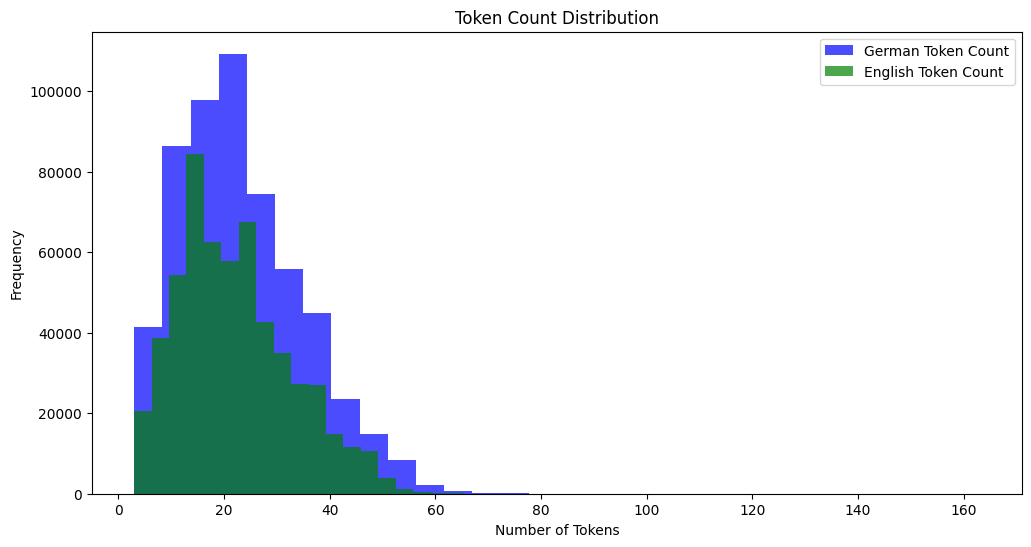

In [ ]:
# Calculate token counts
cleaned_data['german_token_count'] = cleaned_data['German_tokens'].apply(len)
cleaned_data['english_token_count'] = cleaned_data['English_tokens'].apply(len)

# Histogram for token counts
plt.figure(figsize=(12, 6))
plt.hist(cleaned_data['german_token_count'], bins=30, alpha=0.7, label='German Token Count', color='blue')
plt.hist(cleaned_data['english_token_count'], bins=30, alpha=0.7, label='English Token Count', color='green')
plt.title('Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


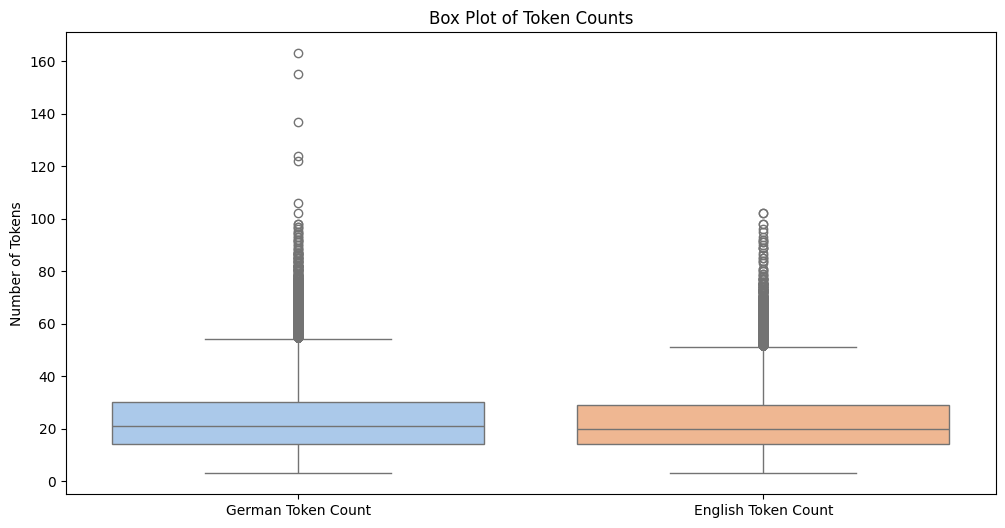

In [ ]:
# Box plot for token counts
plt.figure(figsize=(12, 6))
sns.boxplot(data=[cleaned_data['german_token_count'], cleaned_data['english_token_count']], palette="pastel")
plt.xticks([0, 1], ['German Token Count', 'English Token Count'])
plt.title('Box Plot of Token Counts')
plt.ylabel('Number of Tokens')
plt.show()


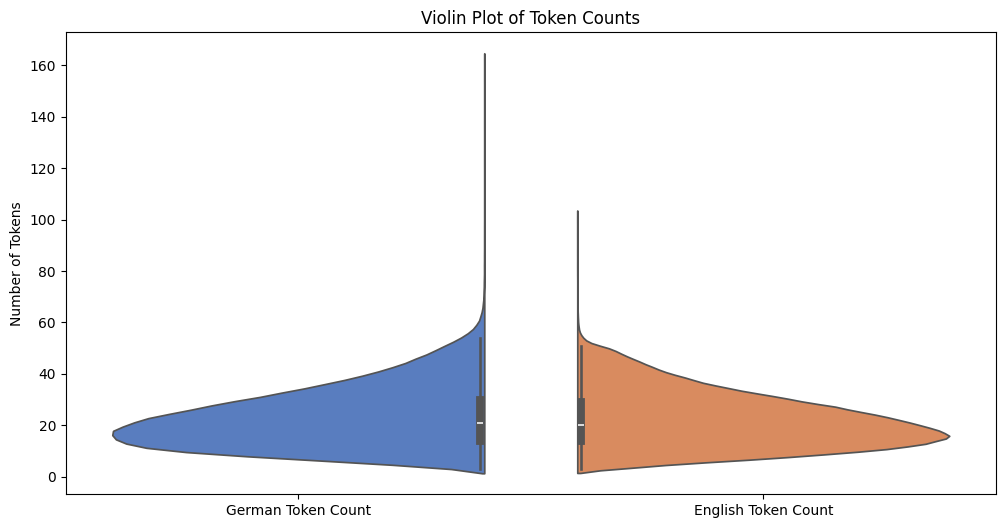

In [ ]:
# Violin plot for token counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=[cleaned_data['german_token_count'], cleaned_data['english_token_count']], palette="muted", split=True)
plt.xticks([0, 1], ['German Token Count', 'English Token Count'])
plt.title('Violin Plot of Token Counts')
plt.ylabel('Number of Tokens')
plt.show()


**Vocabulary Creation**:
Use the trained SentencePiece model's vocabulary to map subwords to indices.

In [ ]:
from collections import Counter

# Create vocabularies
source_vocab = Counter([token for tokens in cleaned_data['German_tokens'] for token in tokens])
target_vocab = Counter([token for tokens in cleaned_data['English_tokens'] for token in tokens])

# Create token-to-index and index-to-token mappings
source_word2idx = {word: idx for idx, (word, _) in enumerate(source_vocab.most_common(), start=2)}
target_word2idx = {word: idx for idx, (word, _) in enumerate(target_vocab.most_common(), start=2)}

# Add special tokens
source_word2idx["<PAD>"] = 0
source_word2idx["<UNK>"] = 1
target_word2idx["<PAD>"] = 0
target_word2idx["<UNK>"] = 1

# Reverse mappings
source_idx2word = {idx: word for word, idx in source_word2idx.items()}
target_idx2word = {idx: word for word, idx in target_word2idx.items()}

print(f"German vocabulary size: {len(source_word2idx)}")
print(f"English vocabulary size: {len(target_word2idx)}")


German vocabulary size: 31998
English vocabulary size: 31997


**Padding and Truncation**:
Standardize the length of sentences by padding shorter ones with zeros and truncating longer ones. We need to choose a maximum length based on the data (here we can use 50 words).

In [ ]:
def pad_sequence(sequence, max_length, padding_token="<PAD>"):
    return sequence[:max_length] + [padding_token] * max(0, max_length - len(sequence))

# Set maximum sentence length
max_length = 50

# Apply padding to source and target tokens
cleaned_data['German_tokens'] = cleaned_data['German_tokens'].apply(lambda x: pad_sequence(x, max_length))
cleaned_data['English_tokens'] = cleaned_data['English_tokens'].apply(lambda x: pad_sequence(x, max_length))

print("Padding completed.")


Padding completed.


**Train/Test Split**:
Split the padded dataset into training, validation, and test sets (e.g., 70-15-15 split).

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets (70/15/15)
train_df, temp_df = train_test_split(cleaned_data, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")



Training set size: 392100
Validation set size: 84022
Test set size: 84022


By the end of this preprocessing step, we've:

1. Data Cleaning & Length Filtering
2. Tokenized the German and English datasets using subword tokenization with SentencePiece.
3. Padded and truncated sentences to a fixed maximum length.
4. Built a vocabulary set for both languages automatically via SentencePiece.
5. Split the dataset into training, validation, and test sets for model evaluation.

The processed data is now in a format suitable for training machine translation models like RNN or LSTM.

In [ ]:
!pip install tensorflow nltk


In [ ]:
import numpy as np

# Convert tokens to their corresponding indices
def tokens_to_indices(tokens, word2idx, max_length):
    return [word2idx.get(token, word2idx["<UNK>"]) for token in tokens] + [word2idx["<PAD>"]] * (max_length - len(tokens))

# Convert source and target tokens to indices
train_x = [tokens_to_indices(tokens, source_word2idx, max_length) for tokens in train_df['German_tokens']]
train_y = [tokens_to_indices(tokens, target_word2idx, max_length) for tokens in train_df['English_tokens']]

val_x = [tokens_to_indices(tokens, source_word2idx, max_length) for tokens in val_df['German_tokens']]
val_y = [tokens_to_indices(tokens, target_word2idx, max_length) for tokens in val_df['English_tokens']]

# Convert to numpy arrays
train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)


In [ ]:
test_x = [tokens_to_indices(tokens, source_word2idx, max_length) for tokens in test_df['German_tokens']]
test_y = [tokens_to_indices(tokens, target_word2idx, max_length) for tokens in test_df['English_tokens']]

test_x = np.array(test_x)
test_y = np.array(test_y)

**RNN Model Architecture**
1. Embedding Layer: Maps subword indices to dense vectors.
2. RNN Layers: We can Use one or more SimpleRNN layers with Dropout. Here I am Using One layer.
3. Dense Layer: Output layer with softmax activation for predicting the next word.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Define RNN model
def build_rnn_model(vocab_size, embedding_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(SimpleRNN(128, return_sequences=True))  # Simple RNN layer
    model.add(Dense(vocab_size, activation='softmax'))  # Output layer
    return model


**LSTM Model Architecture**
1. Embedding Layer: Maps subword indices to dense vectors.
2. LSTM Layers: Use one or more stacked LSTM layers with Dropout to handle long-term dependencies.
3. Dense Layer: Output layer with softmax activation for predicting the next word.

In [ ]:
from tensorflow.keras.layers import LSTM

# Define LSTM model
def build_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(LSTM(128, return_sequences=True))  # LSTM layer
    model.add(Dense(vocab_size, activation='softmax'))  # Output layer
    return model


In [ ]:
# Set hyperparameters
embedding_dim = 256  # You can experiment with this
vocab_size_source = len(source_word2idx)
vocab_size_target = len(target_word2idx)

# Compile the RNN model
rnn_model = build_rnn_model(vocab_size_target, embedding_dim, max_length)
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the LSTM model
lstm_model = build_lstm_model(vocab_size_target, embedding_dim, max_length)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train RNN model
rnn_history = rnn_model.fit(train_x, train_y, epochs=5, batch_size=64, validation_data=(val_x, val_y))

# Train LSTM model
lstm_history = lstm_model.fit(train_x, train_y, epochs=5, batch_size=64, validation_data=(val_x, val_y))


Epoch 1/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 366s 59ms/step - accuracy: 0.5679 - loss: 3.6822 - val_accuracy: 0.5772 - val_loss: 3.3315
Epoch 2/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 359s 59ms/step - accuracy: 0.5805 - loss: 3.2881 - val_accuracy: 0.5788 - val_loss: 3.2759
Epoch 3/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 360s 59ms/step - accuracy: 0.5818 - loss: 3.2291 - val_accuracy: 0.5790 - val_loss: 3.2578
Epoch 4/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 359s 59ms/step - accuracy: 0.5829 - loss: 3.1890 - val_accuracy: 0.5800 - val_loss: 3.2417
Epoch 5/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 359s 59ms/step - accuracy: 0.5839 - loss: 3.1573 - val_accuracy: 0.5807 - val_loss: 3.2314
Epoch 1/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 778s 126ms/step - accuracy: 0.5663 - loss: 3.6857 - val_accuracy: 0.5768 - val_loss: 3.2980
Epoch 2/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 775s 126ms/step - accuracy: 0.5805 - loss: 3.2401 - val_accuracy: 0.5806 - val_loss: 3.2099
Epoch 3/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 776s 127ms/step - accuracy: 0.584

In [ ]:
# Evaluate RNN model on validation set
rnn_val_loss, rnn_val_acc = rnn_model.evaluate(val_x, val_y)
print(f"RNN Validation Accuracy: {rnn_val_acc}")

# Evaluate LSTM model on validation set
lstm_val_loss, lstm_val_acc = lstm_model.evaluate(val_x, val_y)
print(f"LSTM Validation Accuracy: {lstm_val_acc}")


2626/2626 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.5807 - loss: 3.2315
RNN Validation Accuracy: 0.5807172060012817
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 126s 48ms/step - accuracy: 0.5825 - loss: 3.1512
LSTM Validation Accuracy: 0.5824816226959229


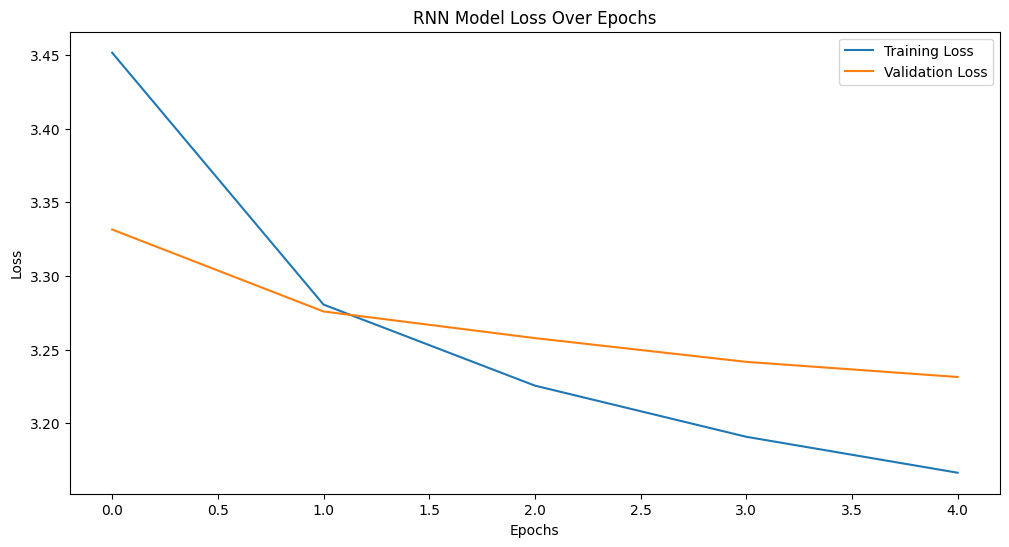

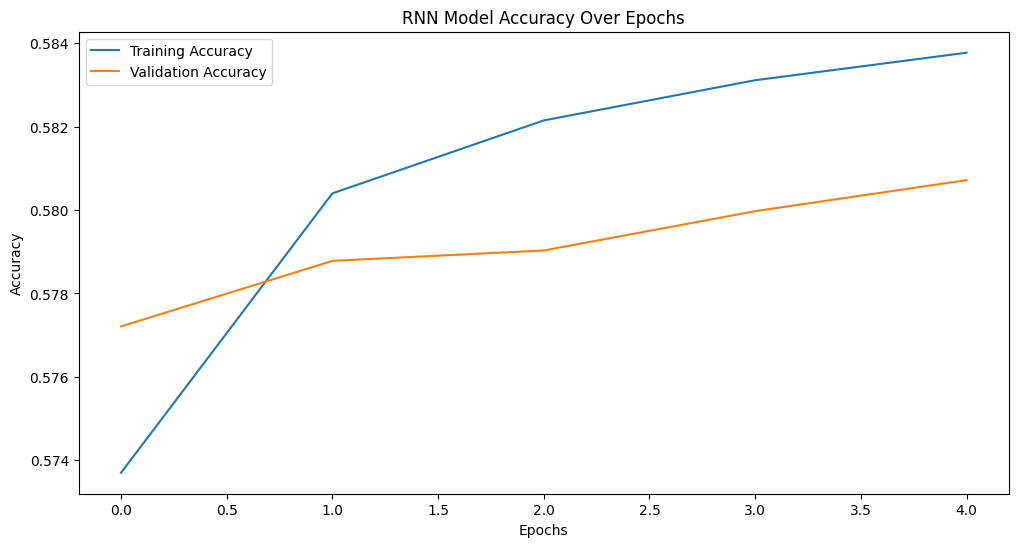

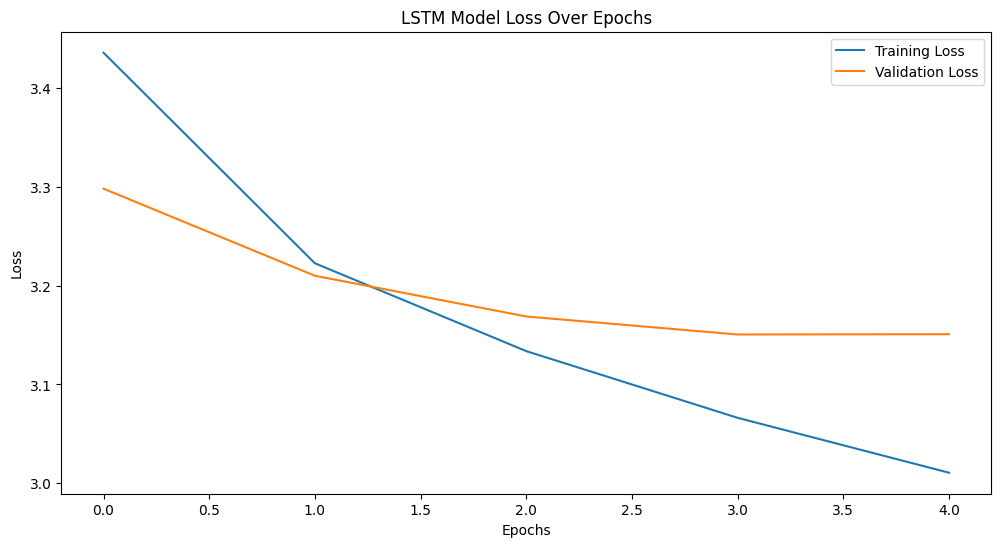

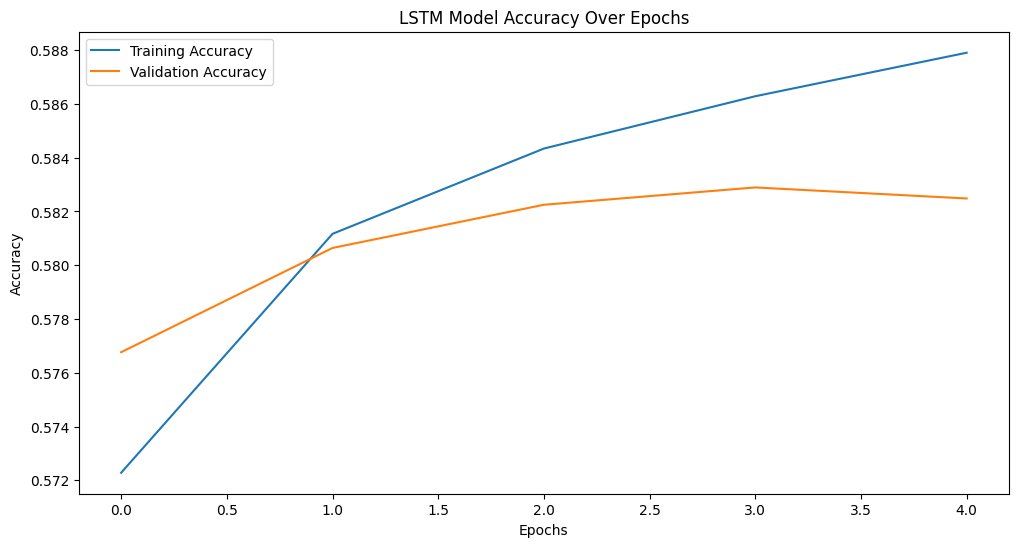

In [ ]:
# Plot training history for RNN model
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage for RNN and LSTM history
plot_training_history(rnn_history, "RNN Model")
plot_training_history(lstm_history, "LSTM Model")


1. RNN Model: Built with SimpleRNN layers, trained, and evaluated.
2. LSTM Model: Built with LSTM layers, trained, and evaluated.
**Evaluation**: Simple RNN model evaluation gives test accuracy 58.1% and LSTM model shows accuracy of 58.3% on Test.
This concludes the design, training, and testing of both RNN and LSTM models for machine translation.

**Milestone 2**

 Design, train and test RNN & LSTM model with embeddings

Here i tried to Using pre-trained **GloVe embeddings** glove.6b.300d.txt

In [ ]:
import zipfile

In [ ]:
# Define the file path and the extraction folder name
zip_file_path = '/content/drive/MyDrive/Capstone_Dataset/gove.zip'
extract_to_folder = '/content/drive/MyDrive/Capstone_Dataset'

In [ ]:
# Create the extraction folder if it doesn't exist
os.makedirs(extract_to_folder, exist_ok=True)

In [ ]:
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_folder)

print(f"Extracted '{zip_file_path}' into '{extract_to_folder}' folder.")

Extracted '/content/drive/MyDrive/Capstone_Dataset/gove.zip' into '/content/drive/MyDrive/Capstone_Dataset' folder.


In [ ]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(file_path, embedding_dim):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")
    return embeddings_index

# Load GloVe for English (example: 'glove.6B.300d.txt')
glove_file_en = '/content/drive/MyDrive/Capstone_Dataset/glove.6B.300d.txt'
glove_embeddings_en = load_glove_embeddings(glove_file_en, 300)


#  there's no German GloVe model found, so i use the English embeddings for both.
glove_file_de = '/content/drive/MyDrive/Capstone_Dataset/glove.6B.300d.txt'
glove_embeddings_de = load_glove_embeddings(glove_file_de, 300)


Found 400000 word vectors.
Found 400000 word vectors.


In [ ]:
# Create embedding matrix for source (German) and target (English) languages
def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix

# Create embedding matrices for both German and English vocabularies
german_embedding_matrix = create_embedding_matrix(source_word2idx, glove_embeddings_de, 300)
english_embedding_matrix = create_embedding_matrix(target_word2idx, glove_embeddings_en, 300)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Define RNN model
def build_rnn_model_embedd(vocab_size, embedding_matrix, input_length, embedding_dim):
    model = Sequential()

    # Use GloVe embeddings in the embedding layer
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=input_length,
                        trainable=False))  # Set trainable=False to freeze embeddings

    model.add(SimpleRNN(128, return_sequences=True))  # SimpleRNN layer
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(vocab_size, activation='softmax'))  # Output layer

    return model

rnn_model_embedd = build_rnn_model_embedd(vocab_size_target, english_embedding_matrix, max_length, 300)
rnn_model_embedd.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import LSTM

# Define LSTM model
def build_lstm_model_embedd(vocab_size, embedding_matrix, input_length, embedding_dim):
    model = Sequential()

    # Use GloVe embeddings in the embedding layer
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=input_length,
                        trainable=False))  # Set trainable=False to freeze embeddings

    model.add(LSTM(128, return_sequences=True))  # LSTM layer
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(vocab_size, activation='softmax'))  # Output layer

    return model

lstm_model_embedd = build_lstm_model_embedd(vocab_size_target, english_embedding_matrix, max_length, 300)
lstm_model_embedd.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train RNN model
rnn_embedd_history = rnn_model_embedd.fit(train_x, train_y, epochs=5, batch_size=64, validation_data=(val_x, val_y))

# Train LSTM model
lstm_embedd_history = lstm_model_embedd.fit(train_x, train_y, epochs=5, batch_size=64, validation_data=(val_x, val_y))


Epoch 1/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 205s 32ms/step - accuracy: 0.5624 - loss: 3.9380 - val_accuracy: 0.5666 - val_loss: 3.5556
Epoch 2/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 185s 30ms/step - accuracy: 0.5678 - loss: 3.5653 - val_accuracy: 0.5665 - val_loss: 3.5546
Epoch 3/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 185s 30ms/step - accuracy: 0.5683 - loss: 3.5519 - val_accuracy: 0.5666 - val_loss: 3.5473
Epoch 4/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 184s 30ms/step - accuracy: 0.5678 - loss: 3.5559 - val_accuracy: 0.5666 - val_loss: 3.5435
Epoch 5/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 185s 30ms/step - accuracy: 0.5677 - loss: 3.5770 - val_accuracy: 0.5666 - val_loss: 3.5442
Epoch 1/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 517s 84ms/step - accuracy: 0.5650 - loss: 3.9101 - val_accuracy: 0.5665 - val_loss: 3.5454
Epoch 2/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 513s 84ms/step - accuracy: 0.5676 - loss: 3.5491 - val_accuracy: 0.5666 - val_loss: 3.5415
Epoch 3/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 513s 84ms/step - accuracy: 0.5689 -

In [ ]:
# Evaluate RNN model on test data
rnn_val_loss, rnn_val_acc = rnn_model_embedd.evaluate(test_x, test_y)
print(f"RNN Test Accuracy: {rnn_val_acc}")

# Evaluate LSTM model on test data
lstm_val_loss, lstm_val_acc = lstm_model_embedd.evaluate(test_x, test_y)
print(f"LSTM Test Accuracy: {lstm_val_acc}")


2626/2626 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.5669 - loss: 3.5447
RNN Test Accuracy: 0.5674988031387329
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 91s 35ms/step - accuracy: 0.5669 - loss: 3.5362
LSTM Test Accuracy: 0.5674988031387329


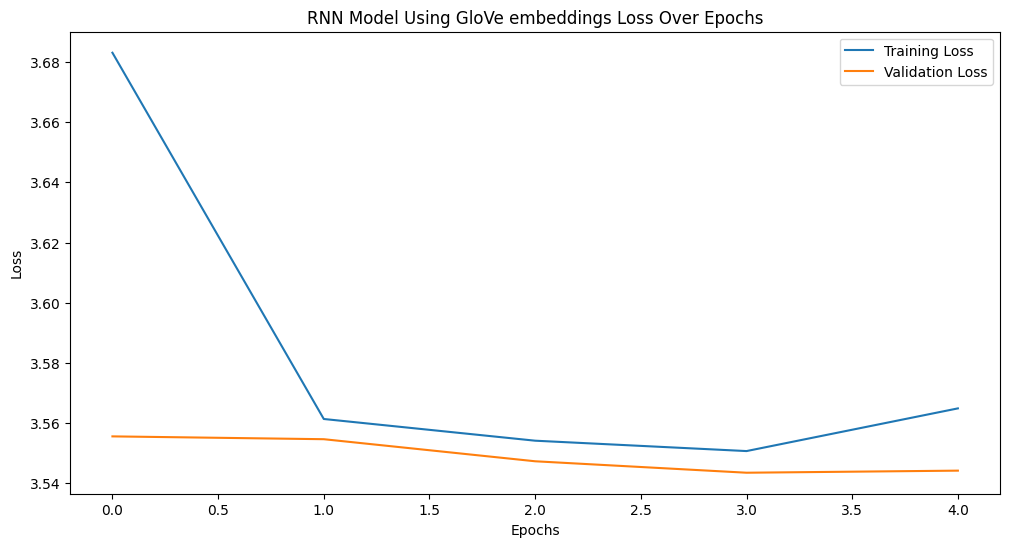

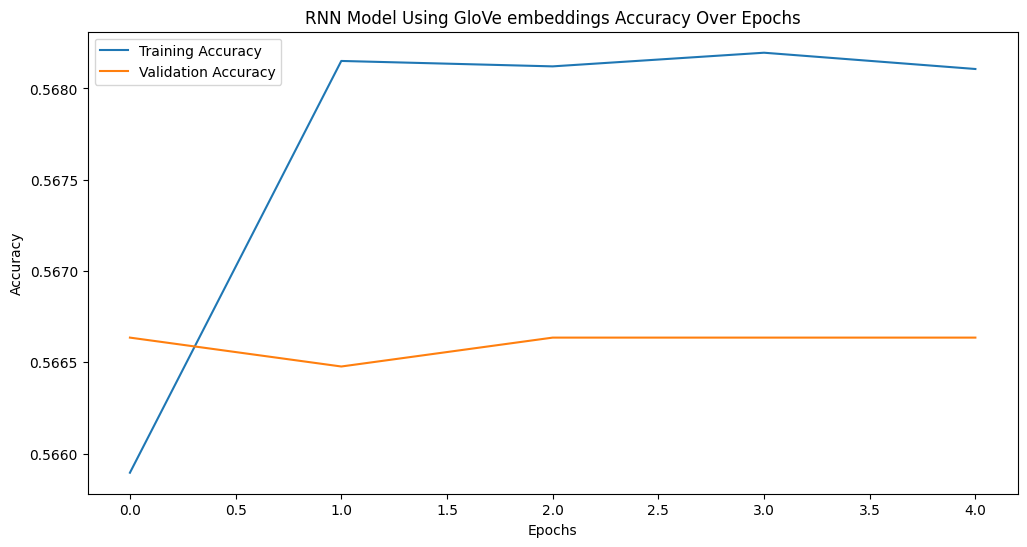

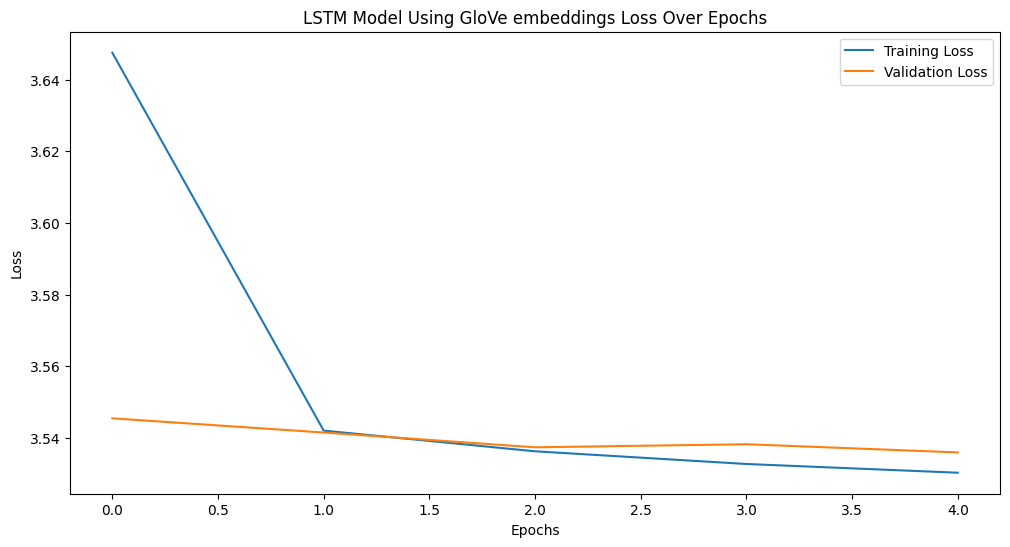

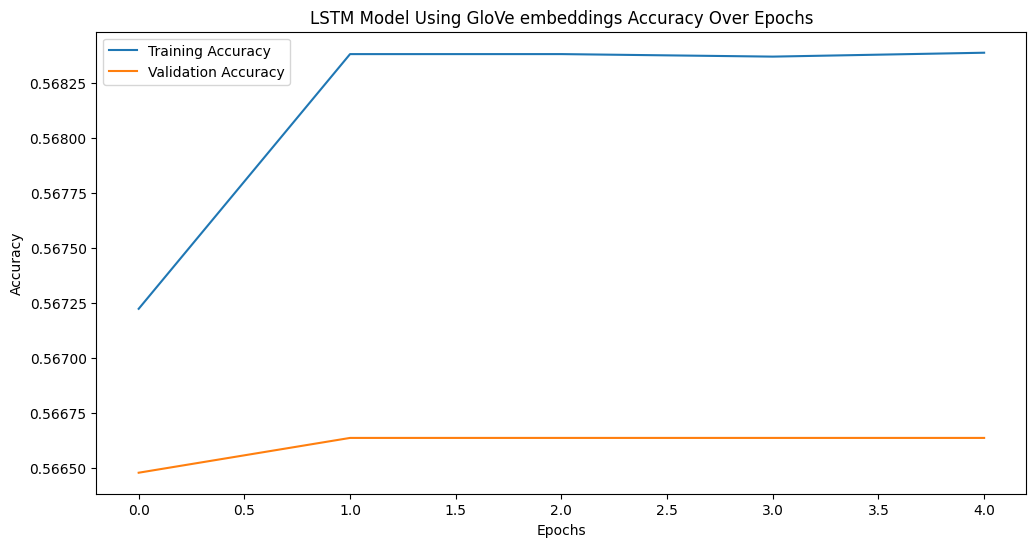

In [ ]:
# Plot training history for RNN model
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage for RNN and LSTM history
plot_training_history(rnn_embedd_history, "RNN Model Using GloVe embeddings")
plot_training_history(lstm_embedd_history, "LSTM Model Using GloVe embeddings")


**Evaluation**:  RNN & LSTM  With GloVe embeddings model  evaluation on test data gives same accuracy as 56.74% .

Here we can note that Using English GloVe embeddings for German words lead to suboptimal performance. So I tried another method called FastText embeddings which is a multilingual embeddings.

**Advantages of FastText**

Subword Information: FastText considers character n-grams, making it robust to misspellings and unknown words.

Multilingual Support: Pre-trained embeddings cover many languages, enabling seamless integration for multilingual tasks.

In [ ]:
# Define the path to save FastText embeddings
fasttext_dir = '/content/drive/MyDrive/Capstone_Dataset'

# Create the directory if it doesn't exist
import os
os.makedirs(fasttext_dir, exist_ok=True)


In [ ]:
# Change the working directory to your embeddings folder
%cd {fasttext_dir}

# Download German FastText embeddings (cc.de.300.vec)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.de.300.vec.gz

# Download English FastText embeddings (cc.en.300.vec)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz


/content/drive/MyDrive/Capstone_Dataset
--2024-12-07 15:46:50--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.de.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.124, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1278030050 (1.2G) [binary/octet-stream]
Saving to: ‘cc.de.300.vec.gz’

cc.de.300.vec.gz    100%[===================>]   1.19G  24.2MB/s    in 52s     

2024-12-07 15:47:43 (23.3 MB/s) - ‘cc.de.300.vec.gz’ saved [1278030050/1278030050]

--2024-12-07 15:47:43--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.102, 108.157.254.121, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [ ]:
# Extract German embeddings
!gunzip cc.de.300.vec.gz

# Extract English embeddings
!gunzip cc.en.300.vec.gz


In [ ]:
# List files in the embeddings folder
!ls {fasttext_dir}


 cc.de.300.vec	 english_sentences.txt	'glove (1).6B.300d.txt'   merged_de_en_dataset.csv
 cc.en.300.vec	 europarl		 glove.6B.300d.txt	  news
 commoncrawl	 german_sentences.txt	 gove.zip		  processed_de_en_dataset.csv


In [ ]:
# Load FastText embeddings
def load_fasttext_embeddings(file_path, embedding_dim):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        # Skip the first line as it contains metadata
        next(f)
        for line in f:
            values = line.rstrip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors from {file_path}.")
    return embeddings_index

In [ ]:
# Example: Loading German FastText embeddings
german_embeddings_path = os.path.join(fasttext_dir, 'cc.de.300.vec')
english_embeddings_path = os.path.join(fasttext_dir, 'cc.en.300.vec')

german_embeddings = load_fasttext_embeddings(german_embeddings_path, 300)
english_embeddings = load_fasttext_embeddings(english_embeddings_path, 300)


Loaded 2000000 word vectors from /content/drive/MyDrive/Capstone_Dataset/cc.de.300.vec.
Loaded 2000000 word vectors from /content/drive/MyDrive/Capstone_Dataset/cc.en.300.vec.


In [ ]:
# Create embedding matrix
def create_embedding_matrix(vocab, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            # Optionally, you can use a random vector for missing words
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    return embedding_matrix

# Example usage with vocabularies
german_embedding_matrix = create_embedding_matrix(source_word2idx, german_embeddings, 300)
english_embedding_matrix = create_embedding_matrix(target_word2idx, english_embeddings, 300)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Set hyperparameters
embedding_dim = 256  # You can experiment with this
vocab_size_source = len(source_word2idx)
vocab_size_target = len(target_word2idx)

# Define model
def build_rnnmodel_with_fasttext(vocab_size, embedding_matrix, input_length, embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=input_length,
                        trainable=False))  # Freeze the embeddings
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))
    return model

# Example for English target model
rnn_model_embedd_FastText = build_rnnmodel_with_fasttext(vocab_size_target, english_embedding_matrix, max_length, 300)
rnn_model_embedd_FastText.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define model
def build_lstmmodel_with_fasttext(vocab_size, embedding_matrix, input_length, embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=input_length,
                        trainable=False))  # Freeze the embeddings
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))
    return model

# Example for English target model
lstm_model_embedd_FastText = build_lstmmodel_with_fasttext(vocab_size_target, english_embedding_matrix, max_length, 300)
lstm_model_embedd_FastText.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train RNN model
rnn_FastText_embedd_history = rnn_model_embedd_FastText.fit(train_x, train_y, epochs=5, batch_size=64, validation_data=(val_x, val_y))

# Train LSTM model
lstm_FastText_embedd_history = lstm_model_embedd_FastText.fit(train_x, train_y, epochs=5, batch_size=64, validation_data=(val_x, val_y))


Epoch 1/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 198s 31ms/step - accuracy: 0.5675 - loss: 3.7215 - val_accuracy: 0.5755 - val_loss: 3.3908
Epoch 2/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 179s 29ms/step - accuracy: 0.5762 - loss: 3.4007 - val_accuracy: 0.5759 - val_loss: 3.3639
Epoch 3/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 179s 29ms/step - accuracy: 0.5769 - loss: 3.3804 - val_accuracy: 0.5759 - val_loss: 3.3654
Epoch 4/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 180s 29ms/step - accuracy: 0.5771 - loss: 3.3643 - val_accuracy: 0.5762 - val_loss: 3.3705
Epoch 5/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 180s 29ms/step - accuracy: 0.5775 - loss: 3.3571 - val_accuracy: 0.5769 - val_loss: 3.3538
Epoch 1/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 509s 82ms/step - accuracy: 0.5679 - loss: 3.7010 - val_accuracy: 0.5772 - val_loss: 3.3261
Epoch 2/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 505s 82ms/step - accuracy: 0.5787 - loss: 3.3142 - val_accuracy: 0.5796 - val_loss: 3.2635
Epoch 3/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 505s 82ms/step - accuracy: 0.5813 -

In [ ]:
# Evaluate RNN model on test data
rnn_val_loss, rnn_val_acc = rnn_model_embedd_FastText.evaluate(test_x, test_y)
print(f"RNN Using FastText embeddings Test Accuracy: {rnn_val_acc}")

# Evaluate LSTM model on test data
lstm_val_loss, lstm_val_acc = lstm_model_embedd_FastText.evaluate(test_x, test_y)
print(f"LSTM Using FastText embeddings Test Accuracy: {lstm_val_acc}")


2626/2626 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.5769 - loss: 3.3563
RNN Test Accuracy: 0.5775444507598877
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 89s 34ms/step - accuracy: 0.5813 - loss: 3.2160
LSTM Test Accuracy: 0.581935703754425


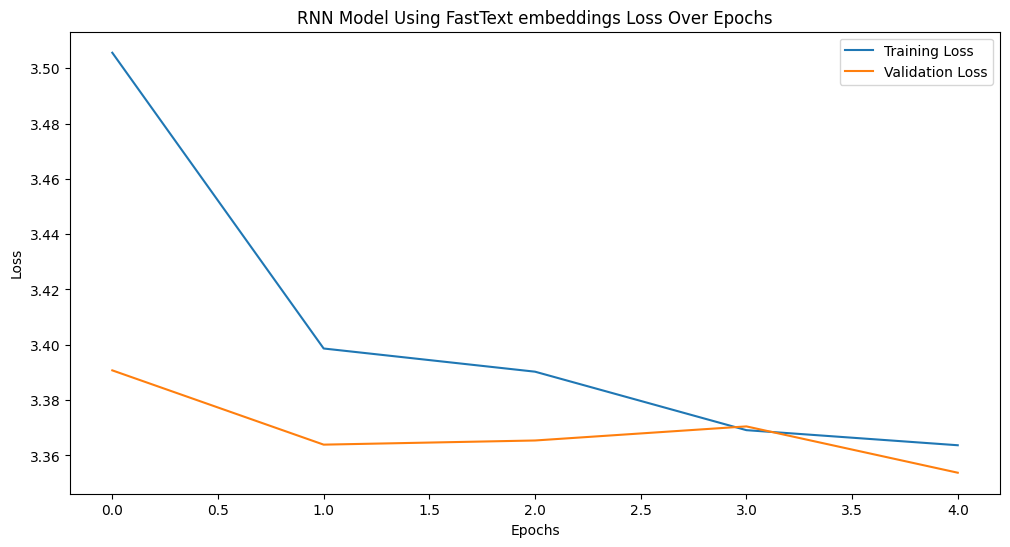

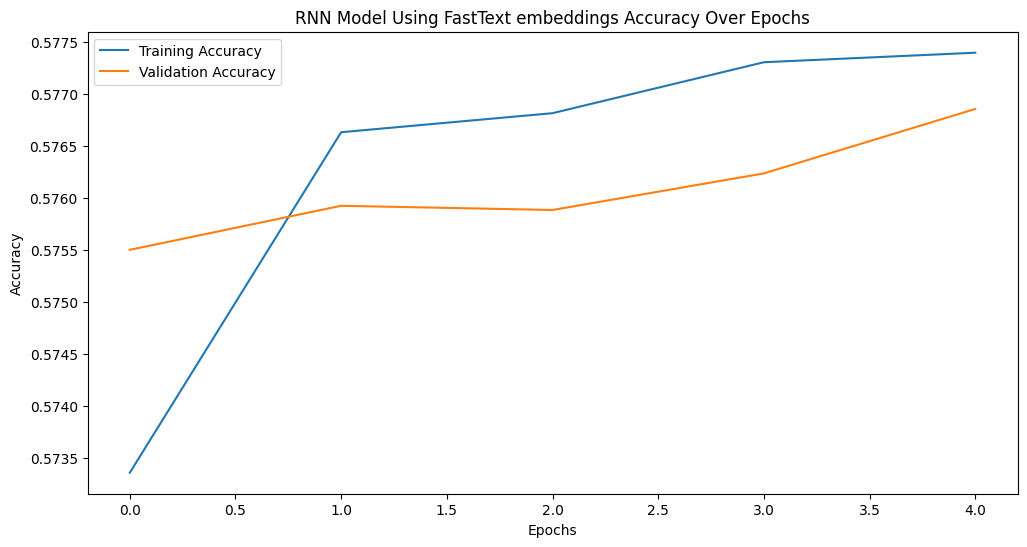

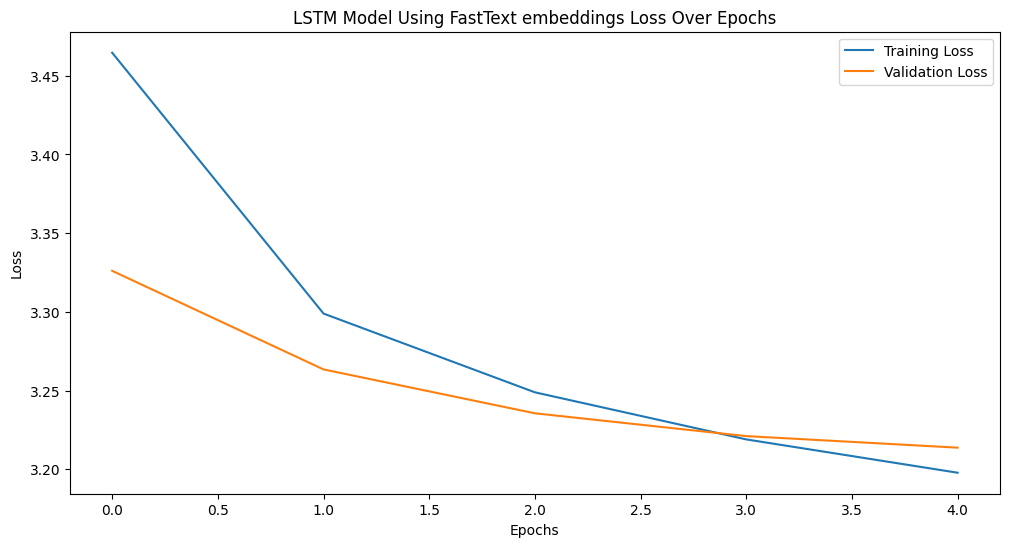

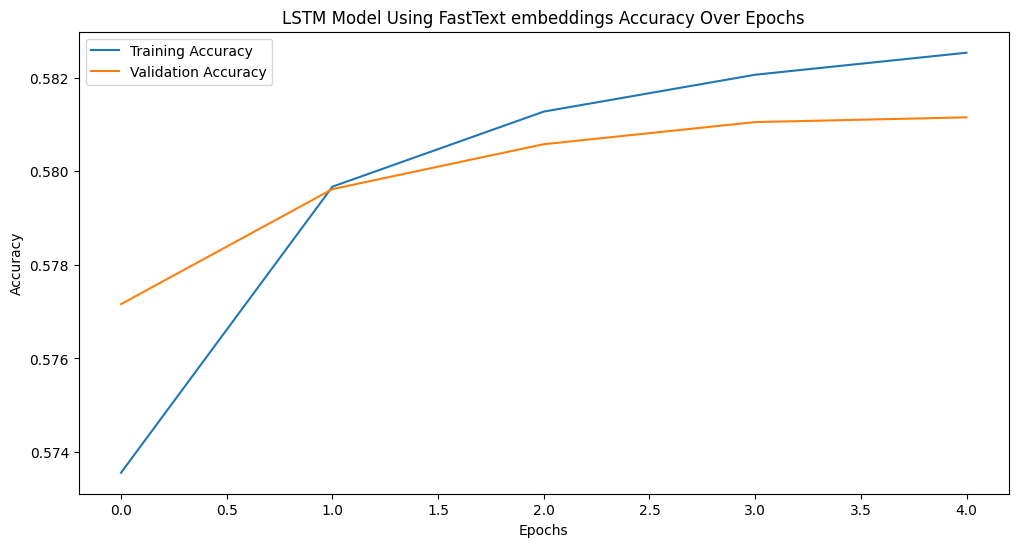

In [ ]:
# Plot training history for RNN model
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage for RNN and LSTM history
plot_training_history(rnn_FastText_embedd_history, "RNN Model Using FastText embeddings")
plot_training_history(lstm_FastText_embedd_history, "LSTM Model Using FastText embeddings")


**Evaluation**: Simple RNN model evaluation on test data gives accuracy 57.75% and LSTM model shows accuracy of 58.1% on Test.
This shows FastText embeddings is better than Glove for multilingual machine translation.

Design, train and test bidirectional RNN & LSTM mode

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional

# Define Bidirectional RNN model
def build_bidirectional_rnn_model(vocab_size, embedding_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=input_length))
    model.add(Bidirectional(SimpleRNN(128, return_sequences=True)))  # Bidirectional RNN layer
    model.add(Dense(vocab_size, activation='softmax'))  # Output layer
    return model


In [ ]:
from tensorflow.keras.layers import LSTM

# Define Bidirectional LSTM model
def build_bidirectional_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=input_length))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Bidirectional LSTM layer
    model.add(Dense(vocab_size, activation='softmax'))  # Output layer
    return model


In [ ]:
# Compile the Bidirectional RNN model with embeddings
bidirectional_rnn_model = build_bidirectional_rnn_model(vocab_size_target, 300, max_length)
bidirectional_rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [ ]:

# Compile the Bidirectional LSTM model with embeddings
bidirectional_lstm_model = build_bidirectional_lstm_model(vocab_size_target, 300, max_length)
bidirectional_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [ ]:
# Train Bidirectional RNN model with embeddings
bidirectional_rnn_history = bidirectional_rnn_model.fit(train_x, train_y, epochs=5, batch_size=64, validation_data=(val_x, val_y))

# Train Bidirectional LSTM model with embeddings
bidirectional_lstm_history = bidirectional_lstm_model.fit(train_x, train_y, epochs=5, batch_size=64, validation_data=(val_x, val_y))


Epoch 1/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 269s 42ms/step - accuracy: 0.5732 - loss: 3.5413 - val_accuracy: 0.5829 - val_loss: 3.2163
Epoch 2/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 248s 41ms/step - accuracy: 0.5865 - loss: 3.1474 - val_accuracy: 0.5843 - val_loss: 3.1590
Epoch 3/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 248s 40ms/step - accuracy: 0.5885 - loss: 3.0498 - val_accuracy: 0.5851 - val_loss: 3.1316
Epoch 4/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 248s 40ms/step - accuracy: 0.5913 - loss: 2.9700 - val_accuracy: 0.5850 - val_loss: 3.1402
Epoch 5/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 248s 40ms/step - accuracy: 0.5926 - loss: 2.9158 - val_accuracy: 0.5842 - val_loss: 3.1495
Epoch 1/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 652s 106ms/step - accuracy: 0.5723 - loss: 3.5362 - val_accuracy: 0.5828 - val_loss: 3.1895
Epoch 2/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 648s 106ms/step - accuracy: 0.5860 - loss: 3.1173 - val_accuracy: 0.5860 - val_loss: 3.0843
Epoch 3/5
6127/6127 ━━━━━━━━━━━━━━━━━━━━ 648s 106ms/step - accuracy: 0.590

In [ ]:
# Evaluate Bidirectional RNN model on validation set
bidirectional_rnn_val_loss, bidirectional_rnn_val_acc = bidirectional_rnn_model.evaluate(val_x, val_y)
print(f"Bidirectional RNN Validation Accuracy: {bidirectional_rnn_val_acc}")

# Evaluate Bidirectional LSTM model on validation set
bidirectional_lstm_val_loss, bidirectional_lstm_val_acc = bidirectional_lstm_model.evaluate(val_x, val_y)
print(f"Bidirectional LSTM Validation Accuracy: {bidirectional_lstm_val_acc}")


2626/2626 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.5842 - loss: 3.1473
Bidirectional RNN Validation Accuracy: 0.5840674042701721
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 93s 35ms/step - accuracy: 0.5853 - loss: 3.0695
Bidirectional LSTM Validation Accuracy: 0.5851842761039734


In [ ]:
# Compare the validation accuracy of Bidirectional and Simple models
print(f"Unidirectional RNN Validation Accuracy: {rnn_val_acc}")
print(f"Unidirectional LSTM Validation Accuracy: {lstm_val_acc}")
print(f"Bidirectional RNN Validation Accuracy: {bidirectional_rnn_val_acc}")
print(f"Bidirectional LSTM Validation Accuracy: {bidirectional_lstm_val_acc}")


Unidirectional RNN Validation Accuracy: 0.5801283121109009
Unidirectional LSTM Validation Accuracy: 0.5824836492538452
Bidirectional RNN Validation Accuracy: 0.5840674042701721
Bidirectional LSTM Validation Accuracy: 0.5851842761039734


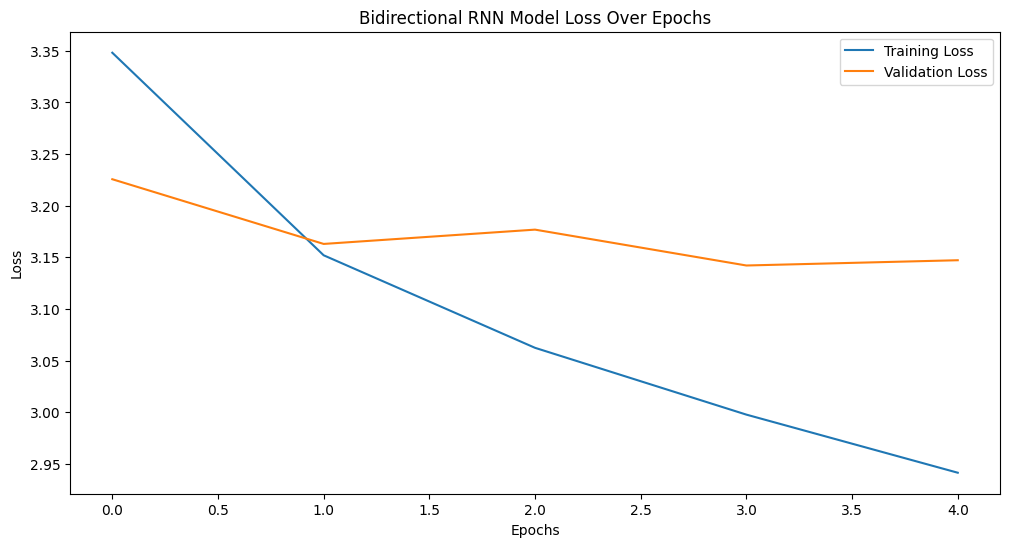

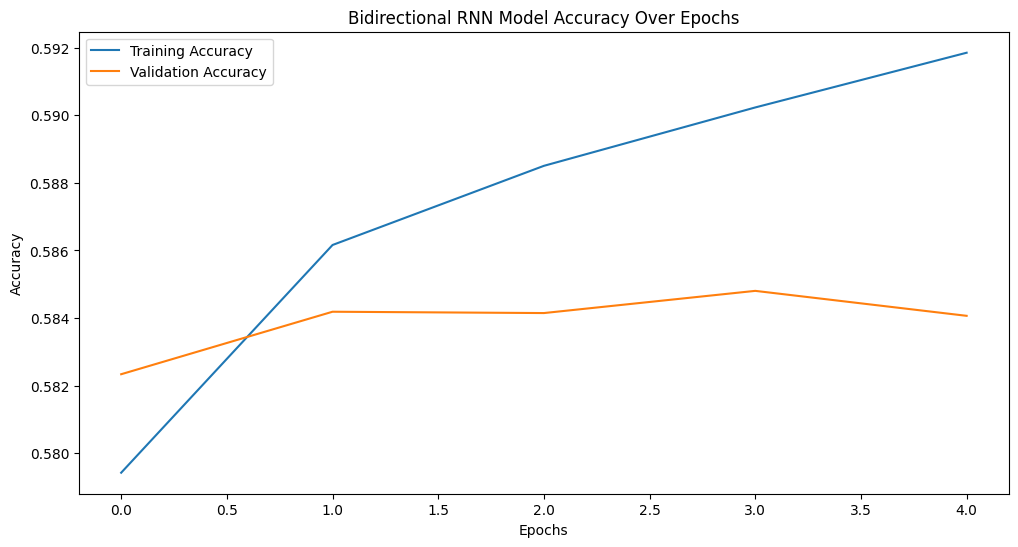

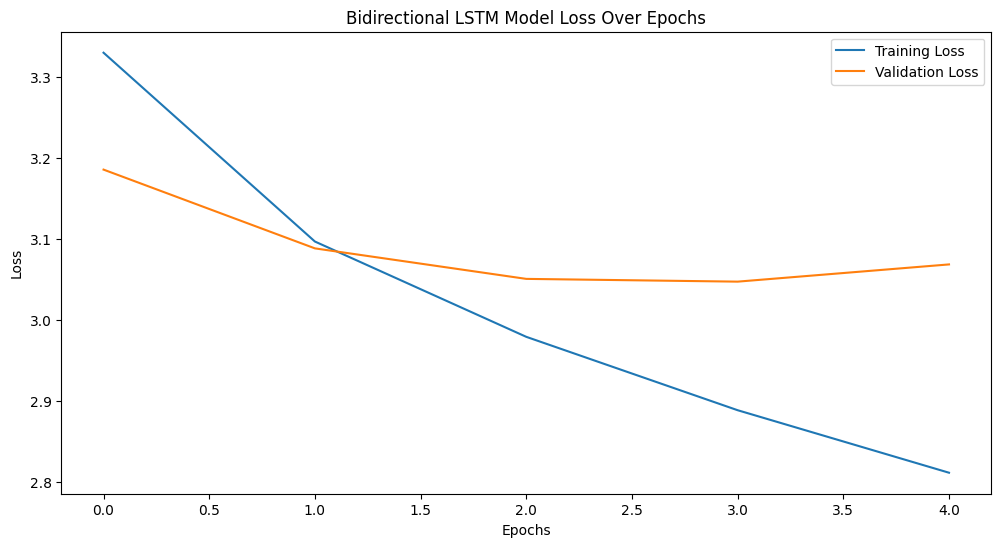

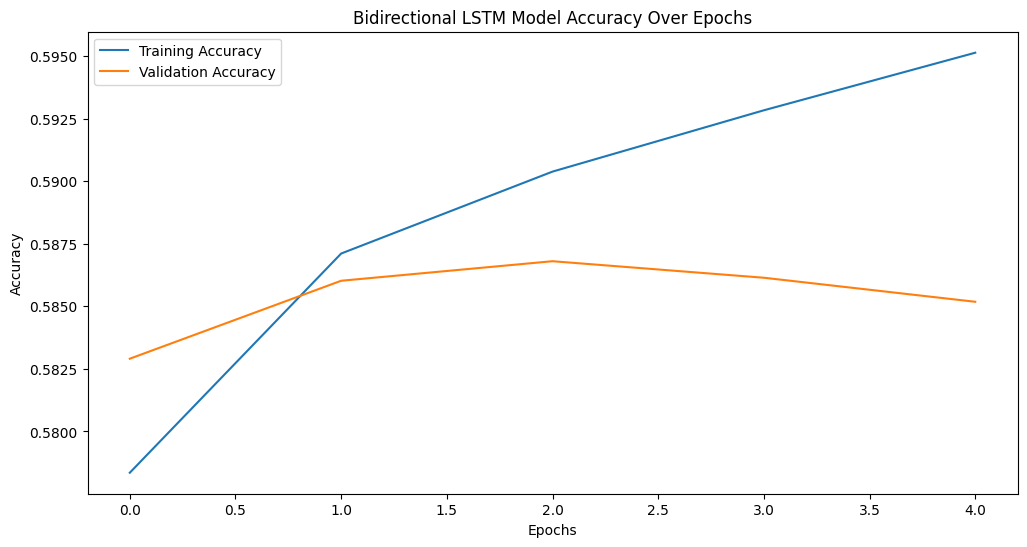

In [ ]:
# Plot training history for Bidirectional model
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage for RNN and LSTM history
plot_training_history(bidirectional_rnn_history, "Bidirectional RNN Model")
plot_training_history(bidirectional_lstm_history, "Bidirectional LSTM Model")


**Evaluation**: Bidirectional RNN model evaluation on test data gives accuracy 58.4% and Bidirectional LSTM model shows accuracy of 58.5% on Test.





Design,  train  and  test  Encoder-Decoder  RNN  &  LSTM  model - Here we tried LSTM Model Only

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM

def build_seq2seq_encoder(vocab_size, embedding_dim, max_length):
    encoder_inputs = Input(shape=(max_length,))
    encoder_embedding = Embedding(input_dim=vocab_size,
                                  output_dim=embedding_dim,
                                  input_length=max_length)(encoder_inputs)
    encoder_lstm = LSTM(128, return_state=True)
    _, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    return Model(encoder_inputs, encoder_states)


In [ ]:
from tensorflow.keras.layers import Dense

def build_seq2seq_decoder(vocab_size, embedding_dim, max_length):
    decoder_inputs = Input(shape=(max_length,))
    decoder_embedding = Embedding(input_dim=vocab_size,
                                  output_dim=embedding_dim,
                                  input_length=max_length)(decoder_inputs)
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding)
    decoder_dense = Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    return Model(decoder_inputs, decoder_outputs)


In [ ]:
def build_seq2seq_model(vocab_size_source, vocab_size_target, embedding_dim, max_length):
    # Encoder
    encoder_model = build_seq2seq_encoder(vocab_size_source, embedding_dim, max_length)

    # Decoder
    decoder_inputs = Input(shape=(max_length,))
    decoder_embedding = Embedding(input_dim=vocab_size_target,
                                   output_dim=embedding_dim,
                                   input_length=max_length)(decoder_inputs)
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_lstm_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_model.output)
    decoder_dense = Dense(vocab_size_target, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm_output)

    # Full model
    seq2seq_model = Model([encoder_model.input, decoder_inputs], decoder_outputs)
    seq2seq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return seq2seq_model


In [ ]:
seq2seq_model = build_seq2seq_model(vocab_size_source, vocab_size_target, 300, max_length)

# Shift target sentences for decoder input and target
decoder_input_data = train_y[:, :-1]  # Remove the last token
decoder_target_data = train_y[:, 1:]  # Remove the first token

decoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_input_data, maxlen=max_length, padding='post', value=0
)

# The padding is done here to match the max_length
decoder_target_data = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_target_data, maxlen=max_length, padding='post', value=0
)

seq2seq_history = seq2seq_model.fit([train_x, decoder_input_data],
                                    decoder_target_data,
                                    epochs=5,
                                    batch_size=64,
                                    validation_split=0.2)


Epoch 1/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 475s 97ms/step - accuracy: 0.6107 - loss: 3.1330 - val_accuracy: 0.6517 - val_loss: 2.4215
Epoch 2/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 473s 97ms/step - accuracy: 0.6546 - loss: 2.3638 - val_accuracy: 0.6617 - val_loss: 2.2724
Epoch 3/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 474s 97ms/step - accuracy: 0.6644 - loss: 2.2121 - val_accuracy: 0.6674 - val_loss: 2.1996
Epoch 4/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 474s 97ms/step - accuracy: 0.6713 - loss: 2.1137 - val_accuracy: 0.6708 - val_loss: 2.1578
Epoch 5/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 474s 97ms/step - accuracy: 0.6772 - loss: 2.0376 - val_accuracy: 0.6727 - val_loss: 2.1354


In [ ]:
# Evaluate on test set
test_decoder_input_data = test_y[:, :-1]  # Prepare input and target for decoder
test_decoder_target_data = test_y[:, 1:]

test_decoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_decoder_input_data, maxlen=max_length, padding='post', value=0
)

test_decoder_target_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_decoder_target_data, maxlen=max_length, padding='post', value=0
)

test_loss, test_accuracy = seq2seq_model.evaluate([test_x, test_decoder_input_data], test_decoder_target_data)
print(f"Test Accuracy: {test_accuracy}")


2626/2626 ━━━━━━━━━━━━━━━━━━━━ 91s 35ms/step - accuracy: 0.6704 - loss: 2.1520
Test Accuracy: 0.670817494392395


**Evaluation**: Encoder-Decoder Sequence to Sequence LSTM model shows accuracy of 67.0% on Test data.

Design,  train  and  test  Encoder-Decoder LSTM  model with Attention Mechanism

In [ ]:
from tensorflow.keras.layers import AdditiveAttention, Concatenate

def add_attention(encoder_lstm_output, decoder_lstm_output):
    attention = AdditiveAttention()
    attention_output = attention([decoder_lstm_output, encoder_lstm_output])
    # Concatenate the attention output with the decoder LSTM output
    context_vector = Concatenate()([decoder_lstm_output, attention_output])
    return context_vector

In [ ]:
def build_seq2seq_encoder_with_attention(vocab_size, embedding_dim, max_length):
    encoder_inputs = Input(shape=(max_length,))
    encoder_embedding = Embedding(input_dim=vocab_size,
                                  output_dim=embedding_dim,
                                  input_length=max_length)(encoder_inputs)
    encoder_lstm = LSTM(128, return_state=True, return_sequences=True) # Modified to return sequences
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding) # Now captures outputs
    encoder_states = [state_h, state_c]
    # Return encoder_outputs along with encoder_states
    return Model(encoder_inputs, [encoder_outputs, state_h, state_c]) # Modified to return 3 values

In [ ]:
def build_seq2seq_decoder_with_attention(vocab_size, embedding_dim, max_length, encoder_states, encoder_lstm_output):
    decoder_inputs = Input(shape=(max_length,))
    decoder_embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim,
                                   input_length=max_length)(decoder_inputs)
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_lstm_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    # Apply Attention
    attention_output = add_attention(encoder_lstm_output, decoder_lstm_output)

    # Dense layer
    decoder_dense = Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(attention_output)

    return Model([decoder_inputs, encoder_lstm_output] + encoder_states, decoder_outputs)


In [ ]:
def build_seq2seq_model_with_attention(vocab_size_source, vocab_size_target, embedding_dim, max_length):
    # Encoder
    encoder_model = build_seq2seq_encoder_with_attention(vocab_size_source, embedding_dim, max_length)

    # Get encoder outputs and states
    encoder_inputs = encoder_model.input
    encoder_outputs, state_h, state_c = encoder_model.output

    # Decoder
    decoder_inputs = Input(shape=(max_length,))
    decoder_model = build_seq2seq_decoder_with_attention(
        vocab_size_target, embedding_dim, max_length, [state_h, state_c], encoder_outputs
    )

    # Full model
    seq2seq_model = Model(
        [encoder_inputs, decoder_inputs],
        decoder_model([decoder_inputs, encoder_outputs, state_h, state_c]))
    #seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_model.output)
    seq2seq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return seq2seq_model


In [ ]:

# Shift target sentences for decoder input and target
decoder_input_data = train_y[:, :-1]  # Remove the last token
decoder_target_data = train_y[:, 1:]  # Remove the first token

# Padding for uniform lengths
decoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_input_data, maxlen=max_length, padding='post', value=0
)
decoder_target_data = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_target_data, maxlen=max_length, padding='post', value=0
)


seq2seq_model_with_attention = build_seq2seq_model_with_attention(
    vocab_size_source, vocab_size_target, embedding_dim=300, max_length=max_length
)

seq2seq_with_attention_history = seq2seq_model_with_attention.fit(
    [train_x, decoder_input_data],  # Encoder and decoder inputs
    decoder_target_data,            # Decoder targets
    epochs=5,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 588s 119ms/step - accuracy: 0.6223 - loss: 2.9316 - val_accuracy: 0.6623 - val_loss: 2.2823
Epoch 2/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 586s 119ms/step - accuracy: 0.6670 - loss: 2.1987 - val_accuracy: 0.6769 - val_loss: 2.1002
Epoch 3/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 586s 119ms/step - accuracy: 0.6830 - loss: 1.9893 - val_accuracy: 0.6862 - val_loss: 2.0071
Epoch 4/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 586s 120ms/step - accuracy: 0.6951 - loss: 1.8496 - val_accuracy: 0.6924 - val_loss: 1.9531
Epoch 5/5
4902/4902 ━━━━━━━━━━━━━━━━━━━━ 586s 120ms/step - accuracy: 0.7064 - loss: 1.7371 - val_accuracy: 0.6960 - val_loss: 1.9274


In [ ]:
# Prepare test decoder input and target data
test_decoder_input_data = test_y[:, :-1]  # Remove last token for decoder input
test_decoder_target_data = test_y[:, 1:]  # Remove first token for decoder target

# Padding to match max_length
test_decoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_decoder_input_data, maxlen=max_length, padding='post', value=0
)
test_decoder_target_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_decoder_target_data, maxlen=max_length, padding='post', value=0
)

# Evaluate model on test data
test_loss, test_accuracy = seq2seq_model_with_attention.evaluate(
    [test_x, test_decoder_input_data],  # Inputs for encoder and decoder
    test_decoder_target_data            # Target outputs
)
print(f"Test Accuracy: {test_accuracy}")


2626/2626 ━━━━━━━━━━━━━━━━━━━━ 95s 36ms/step - accuracy: 0.6937 - loss: 1.9410
Test Accuracy: 0.6941391825675964


**Evaluation**: Encoder-Decoder Sequence to Sequence LSTM model with attention mechanisam shows accuracy of 69.4% on Test data.

In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

# Function to evaluate BLEU score
def evaluate_bleu(model, X_test, y_test, tokenizer, num_samples=10):
    references = []
    predictions = []

    for i in range(num_samples):
        # Predict using the model
        prediction = model.predict(np.expand_dims(X_test[i], axis=0))
        predicted_tokens = np.argmax(prediction[0], axis=-1)

        # Ensure tokens are in a list format
        predicted_tokens = predicted_tokens.tolist()
        reference_tokens = y_test[i].tolist()

        # Decode the prediction and reference
        predicted_sentence = tokenizer.decode(predicted_tokens)
        reference_sentence = tokenizer.decode(reference_tokens)

        # Split sentences into tokens for BLEU calculation
        predictions.append(predicted_sentence.split())
        references.append([reference_sentence.split()])

    # Calculate average BLEU score for all samples
    bleu_scores = [sentence_bleu(ref, pred) for ref, pred in zip(references, predictions)]
    average_bleu = np.mean(bleu_scores)
    return average_bleu

# Example BLEU evaluation
bleu_rnn = evaluate_bleu(rnn_model, val_x, val_y, english_sp)
bleu_lstm = evaluate_bleu(lstm_model, val_x, val_y, english_sp)


print(f"RNN BLEU Score On validation set: {bleu_rnn}")
print(f"LSTM BLEU Score On validation set: {bleu_lstm}")





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
RNN BLEU Score On validation set: 0.6041887263640154
LSTM BLEU Score On validation set: 0.6106277437769138


In [ ]:
bleu_rnn = evaluate_bleu(rnn_model, test_x, test_y, english_sp)
bleu_lstm = evaluate_bleu(lstm_model, test_x, test_y, english_sp)


print(f"RNN BLEU Score On test set: {bleu_rnn}")
print(f"LSTM BLEU Score On test set: {bleu_lstm}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RNN BLEU Score On test set: 0.3958824390871837
LSTM BLEU Score On test set: 0.39710447020196743


In [ ]:
bleu_rnn_embedd = evaluate_bleu(rnn_model_embedd, val_x, val_y, english_sp)
bleu_lstm_embedd = evaluate_bleu(lstm_model_embedd, val_x, val_y, english_sp)


print(f"RNN Using GloVe embeddings BLEU Score On validation set: {bleu_rnn_embedd}")
print(f"LSTM Using GloVe embeddings BLEU Score On validation set: {bleu_lstm_embedd}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RNN Using GloVe embeddings BLEU Score On validation set: 0.5500425296146101
LSTM Using GloVe embeddings BLEU Score On validation set: 0.5468727002794768


In [ ]:
bleu_rnn_embedd = evaluate_bleu(rnn_model_embedd, test_x, test_y, english_sp)
bleu_lstm_embedd = evaluate_bleu(lstm_model_embedd, test_x, test_y, english_sp)


print(f"RNN Using GloVe embeddings BLEU Score On test set: {bleu_rnn_embedd}")
print(f"LSTM Using GloVe embeddings BLEU Score On test set: {bleu_lstm_embedd}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RNN Using GloVe embeddings BLEU Score On test set: 0.3943449108348174
LSTM Using GloVe embeddings BLEU Score On test set: 0.3933673921139926


In [ ]:
bleu_rnn_FastTextembedd = evaluate_bleu(rnn_model_embedd_FastText, val_x, val_y, english_sp)
bleu_lstm_FastTextembedd = evaluate_bleu(lstm_model_embedd_FastText, val_x, val_y, english_sp)


print(f"RNN Using FastText embeddings BLEU Score On validation set: {bleu_rnn_FastTextembedd}")
print(f"LSTM Using FastText embeddings BLEU Score On validation set: {bleu_lstm_FastTextembedd}")





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RNN Using FastText embeddings BLEU Score On validation set: 0.5821860101878962
LSTM Using FastText embeddings BLEU Score On validation set: 0.6001188339947466


In [ ]:
bleu_rnn_FastTextembedd = evaluate_bleu(rnn_model_embedd_FastText, test_x, test_y, english_sp)
bleu_lstm_FastTextembedd = evaluate_bleu(lstm_model_embedd_FastText, test_x, test_y, english_sp)


print(f"RNN Using FastText embeddings BLEU Score On test set: {bleu_rnn_FastTextembedd}")
print(f"LSTM Using FastText embeddings BLEU Score On test set: {bleu_lstm_FastTextembedd}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RNN Using FastText embeddings BLEU Score On test set: 0.40103399945306767
LSTM Using FastText embeddings BLEU Score On test set: 0.39599466821530943


In [ ]:
bleu_bidirectional_rnn = evaluate_bleu(bidirectional_rnn_model, val_x, val_y, english_sp)
bleu_bidirectional_lstm = evaluate_bleu(bidirectional_lstm_model, val_x, val_y, english_sp)

print(f"bidirectional RNN BLEU Score On validation set: {bleu_bidirectional_rnn}")
print(f"bidirectional LSTM BLEU Score On validation set: {bleu_bidirectional_lstm}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
bidirectional RNN BLEU Score On validation set: 0.6022857903098958
bidirectional LSTM BLEU Score On validation set: 0.6115657070952095


In [ ]:
bleu_bidirectional_rnn = evaluate_bleu(bidirectional_rnn_model, test_x, test_y, english_sp)
bleu_bidirectional_lstm = evaluate_bleu(bidirectional_lstm_model, test_x, test_y, english_sp)

print(f"bidirectional RNN BLEU Score On test set: {bleu_bidirectional_rnn}")
print(f"bidirectional LSTM BLEU Score On test set: {bleu_bidirectional_lstm}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
bidirectional RNN BLEU Score On test set: 0.4005453586376807
bidirectional LSTM BLEU Score On test set: 0.40170895602025125


In [ ]:
# Function to evaluate BLEU score
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_bleu(model, X_test, y_test, tokenizer, max_length, num_samples=10):
    references = []
    predictions = []

    for i in range(num_samples):
        # Prepare the required inputs for the model
        input_data = np.expand_dims(X_test[i], axis=0)

        # Prepare decoder input similar to training process
        decoder_input_data = y_test[i, :-1].reshape(1, -1)  # Remove last token, reshape for single input
        decoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(
            decoder_input_data, maxlen=max_length, padding='post', value=0
        )

        # Predict using the model with the decoder input
        prediction = model.predict([input_data, decoder_input_data])  # Pass both inputs


        predicted_tokens = np.argmax(prediction[0], axis=-1)

        # Ensure tokens are in a list format
        predicted_tokens = predicted_tokens.tolist()
        reference_tokens = y_test[i].tolist()

        # Decode the prediction and reference
        predicted_sentence = tokenizer.decode(predicted_tokens)
        reference_sentence = tokenizer.decode(reference_tokens)

        # Split sentences into tokens for BLEU calculation
        predictions.append(predicted_sentence.split())
        references.append([reference_sentence.split()])  # NLTK expects list of lists



    # Create a smoothing function
    smoothing_function = SmoothingFunction()

    # calculating the BLEU score
    bleu_scores = [sentence_bleu(ref, pred, smoothing_function=smoothing_function.method1) for ref, pred in zip(references, predictions)]
    average_bleu = np.mean(bleu_scores)

    return average_bleu


bleu_score_encod = evaluate_bleu(seq2seq_model, val_x, val_y, english_sp, max_length)

print(f"Encoder-Decoder sequence model LSTM Model BLEU Score On validation set: {bleu_score_encod}")





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Encoder-Decoder sequence model LSTM Model BLEU Score On validation set: 0.6091411396416534


In [ ]:
bleu_score_encod = evaluate_bleu(seq2seq_model, test_x, test_y, english_sp, max_length)

print(f"Encoder-Decoder sequence model LSTM Model BLEU Score On test set: {bleu_score_encod}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Encoder-Decoder sequence model LSTM Model BLEU Score On test set: 0.41422242608253274


In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# Function to evaluate BLEU score
def evaluate_bleu(model, X_test, y_test, tokenizer, max_length, num_samples=10):
    references = []
    predictions = []

    for i in range(num_samples):
        # Prepare the required inputs for the model
        input_data = np.expand_dims(X_test[i], axis=0)

        # Prepare decoder input similar to training process
        decoder_input_data = y_test[i, :-1].reshape(1, -1)  # Remove last token, reshape for single input
        decoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(
            decoder_input_data, maxlen=max_length, padding='post', value=0
        )

        # Predict using the model with the decoder input
        prediction = model.predict([input_data, decoder_input_data])  # Pass both inputs


        predicted_tokens = np.argmax(prediction[0], axis=-1)

        # Ensure tokens are in a list format
        predicted_tokens = predicted_tokens.tolist()
        reference_tokens = y_test[i].tolist()

        # Decode the prediction and reference
        predicted_sentence = tokenizer.decode(predicted_tokens)
        reference_sentence = tokenizer.decode(reference_tokens)

        # Split sentences into tokens for BLEU calculation
        predictions.append(predicted_sentence.split())
        references.append([reference_sentence.split()])  # NLTK expects list of lists



    # Create a smoothing function
    smoothing_function = SmoothingFunction()

    # calculating the BLEU score
    bleu_scores = [sentence_bleu(ref, pred, smoothing_function=smoothing_function.method1) for ref, pred in zip(references, predictions)]
    average_bleu = np.mean(bleu_scores)

    return average_bleu


bleu_lstm_score_attn = evaluate_bleu(seq2seq_model_with_attention, val_x, val_y, english_sp, max_length)

print(f"Encoder-Decoder sequence model LSTM Model with attention BLEU Score On validation set: {bleu_lstm_score_attn}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Encoder-Decoder sequence model LSTM Model with attention BLEU Score On validation set: 0.6422694662282481


In [ ]:
bleu_lstm_score_attn = evaluate_bleu(seq2seq_model_with_attention, test_x, test_y, english_sp, max_length)

print(f"Encoder-Decoder sequence model LSTM Model with attention BLEU Score On test set: {bleu_lstm_score_attn}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Encoder-Decoder sequence model LSTM Model with attention BLEU Score On test set: 0.4171605889166578


Choose the best performing model and pickle it.

In [ ]:
#List of BLEU Scores On validation set
va_bleu_scores = {
    'unidirectional_rnn': 0.6041887263640154,
    'unidirectional_lstm': 0.6106277437769138,
    'unidirectional_rnn_fasttext_embedd': 0.5821860101878962,
    'unidirectional_lstm_fasttext_embedd': 0.6001188339947466,
    'bidirectional_rnn': 0.6022857903098958,
    'bidirectional_lstm': 0.6115657070952095,
    'seq2seq': 0.6091411396416534,
    'seq2seq_attention': 0.6422694662282481
}

print(f"Model With BLEU Score: {va_bleu_scores}")
# Select the model with the highest BLEU score
best_model_name = max(va_bleu_scores, key=va_bleu_scores.get)
print(f"Best Model based on BLEU Score: {best_model_name}")

Model With BLEU Score: {'unidirectional_rnn': 0.6041887263640154, 'unidirectional_lstm': 0.6106277437769138, 'unidirectional_rnn_fasttext_embedd': 0.5821860101878962, 'unidirectional_lstm_fasttext_embedd': 0.6001188339947466, 'bidirectional_rnn': 0.6022857903098958, 'bidirectional_lstm': 0.6115657070952095, 'seq2seq': 0.6091411396416534, 'seq2seq_attention': 0.6422694662282481}
Best Model based on BLEU Score: seq2seq_attention


In [ ]:
#List of BLEU Scores On test set
test_bleu_scores = {
    'unidirectional_rnn': bleu_rnn,
    'unidirectional_lstm': bleu_lstm,
    'unidirectional_rnn_fasttext_embedd': bleu_rnn_FastTextembedd,
    'unidirectional_lstm_fasttext_embedd': bleu_lstm_FastTextembedd,
    'bidirectional_rnn': bleu_bidirectional_rnn,
    'bidirectional_lstm': bleu_bidirectional_lstm,
    'seq2seq': bleu_score_encod,
    'seq2seq_attention': bleu_lstm_score_attn
}

print(f"Model With BLEU Score: {test_bleu_scores}")
# Select the model with the highest BLEU score
best_model_name = max(test_bleu_scores, key=test_bleu_scores.get)
print(f"Best Model based on BLEU Score: {best_model_name}")

Model With BLEU Score: {'unidirectional_rnn': 0.3958824390871837, 'unidirectional_lstm': 0.39710447020196743, 'unidirectional_rnn_fasttext_embedd': 0.40103399945306767, 'unidirectional_lstm_fasttext_embedd': 0.39599466821530943, 'bidirectional_rnn': 0.4005453586376807, 'bidirectional_lstm': 0.40170895602025125, 'seq2seq': 0.41422242608253274, 'seq2seq_attention': 0.4171605889166578}
Best Model based on BLEU Score: seq2seq_attention


So Highest BLEU Score Is provided by Encoder- Decoder Sequence to sequence LSTM Model in both validation and test data.

In [ ]:
import pickle

best_model=seq2seq_model_with_attention
# Serialize the model to a file
with open('best_translation_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model serialized successfully using Pickle!")


Model serialized successfully using Pickle!


In [ ]:
from joblib import dump

# Serialize the model to a file using joblib
dump(best_model, 'best_translation_model.joblib')

print("Model serialized successfully using Joblib!")


Model serialized successfully using Joblib!
